In [1]:
import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score
import scipy
import time

from models.sub_cos_glm import Sub_Cos_GLM
from models.sub_tcn import Sub_TCN
from models.gru import GRU

# Cosine Bases

In [2]:
cos_basis_no = 30
scale = 7.5
shift = 1
T_no = 500
        
kern_basis = torch.zeros(cos_basis_no, T_no)
for i in range(cos_basis_no):
    phi = 1.5707963267948966*i
    xmin = phi - 3.141592653589793
    xmax = phi + 3.141592653589793

    x_in = torch.arange(0, T_no, 1)
    raw_cos = scale  * torch.log(x_in + shift + 1e-7)

    basis = 0.5*torch.cos(raw_cos - phi) + 0.5
    basis[raw_cos < xmin] = 0.0
    basis[raw_cos > xmax] = 0.0
    kern_basis[i] = basis

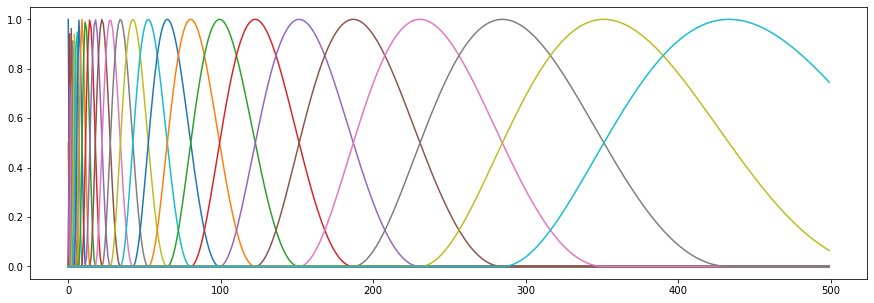

In [3]:
plt.figure(figsize = (15,5))
for i in range(cos_basis_no):
    plt.plot(kern_basis[i].cpu().detach().numpy())

# Hyperparameters

In [2]:
base_dir = "/media/hdd01/sklee/"
experiment = "clust12-20"
cell_type = "CA1"
E_neural_file = "Espikes_neural.npz"
I_neural_file = "Ispikes_neural.npz"
#V_file  = "vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy"
#V_file = "vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_noDendNa_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy"
V_file = "V_diff_stimseed1.npy"

E_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+E_neural_file)
I_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+I_neural_file)
#V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)[:,:50000].flatten()
V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)
V = torch.from_numpy(V)
#V -= torch.mean(V)

eloc_file = "Elocs_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy"
iloc_file = "Ilocs_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy"
eloc = np.load(base_dir+cell_type+"_"+experiment+"/data/"+eloc_file)
iloc = np.load(base_dir+cell_type+"_"+experiment+"/data/"+iloc_file)

den_idx = np.unique(eloc[880:1120,0])
e_idx = np.where(np.isin(eloc[:,0], den_idx) == True)[0]
i_idx = np.where(np.isin(iloc[:,0], den_idx) == True)[0]
e_idx = torch.from_numpy(e_idx)
i_idx = torch.from_numpy(i_idx)

C_syn_e = np.load("/media/hdd01/sklee/CA1_clust12-20/data/handsub18_C_syn_e.npy")
C_syn_i = np.load("/media/hdd01/sklee/CA1_clust12-20/data/handsub18_C_syn_i.npy")
C_syn_e = torch.from_numpy(C_syn_e).float()
C_syn_i = torch.from_numpy(C_syn_i).float()

C_syn_e = C_syn_e[:,e_idx]
C_syn_i = C_syn_i[:,i_idx]

In [3]:
T_train = 980 * 1000 * 50
T_test = 1 * 1000 * 50
H_no = 2
sub_no = 18
#E_no = 2000
#I_no = 200
E_no = e_idx.shape[0]
I_no = i_idx.shape[0]
T_no = 500
device = torch.device("cuda")

increment = 50
batch_length = 50000
batch_size = 4
iter_no = 9800*2
epoch_no = iter_no*batch_length*batch_size//T_train

# Preprocess

In [4]:
V_train = V[:T_train].float()
V_test = V[-50000:].to(device).float()

test_E_neural = E_neural[-50000:].toarray()
test_I_neural = I_neural[-50000:].toarray()
train_E_neural = E_neural[:T_train]
train_I_neural = I_neural[:T_train]

test_E_neural = torch.from_numpy(test_E_neural).float().to(device)
test_I_neural = torch.from_numpy(test_I_neural).float().to(device)

train_idx = np.empty((epoch_no, T_train//batch_length//batch_size))
for i in range(epoch_no):
    part_idx = np.arange(0, T_train, batch_length*batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

# Train

In [5]:
model = Sub_Cos_GLM(C_syn_e.to(device), C_syn_i.to(device), T_no, H_no, device)
#model = GRU(C_syn_e.to(device), C_syn_i.to(device), H_no, device)
#model = Sub_TCN(C_syn_e.to(device), C_syn_i.to(device), T_no, H_no, device)

# GLM (1.025 for V_diff, 1 for noNA)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.005/(1.025**100))
milestones = np.arange(increment-1, increment*100, increment)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=1.025)

# GRU (1 for V_diff, 1 for noNA)
#optimizer = torch.optim.Adam(model.parameters(), lr = 0.0025/(1**100))
#milestones = np.arange(increment-1, increment*100, increment)
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=1)

model.to(device).float()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

2749


In [6]:
score_list = []

for i in tnrange(iter_no):
    s = time.time()
    model.train()
    optimizer.zero_grad()
    
    batch_idx = train_idx[i].long()
    batch_E_neural = train_E_neural[batch_idx : batch_idx+batch_length*batch_size].toarray().reshape(batch_size, batch_length, -1)
    batch_I_neural = train_I_neural[batch_idx : batch_idx+batch_length*batch_size].toarray().reshape(batch_size, batch_length, -1)
    batch_E_neural = torch.from_numpy(batch_E_neural).float().to(device)
    batch_I_neural = torch.from_numpy(batch_I_neural).float().to(device)
    batch_V = V_train[batch_idx : batch_idx+batch_length*batch_size].reshape(batch_size, -1).to(device)
    
    #V_pred, _ = model(batch_E_neural, batch_I_neural)
    V_pred, _, _ = model(batch_E_neural[:,5000:35000,e_idx], batch_I_neural[:,5000:35000,i_idx])
    s = time.time()
    
    loss = torch.mean((V_pred- batch_V[:,5000:35000] )**2)
    loss.backward()
    optimizer.step()
    scheduler.step()
    
    if (i%50 == 49) or (i == 0):
        model.eval()
        #test_V_pred, test_sub_out = model(test_E_neural.unsqueeze(0), test_I_neural.unsqueeze(0))
        test_V_pred, test_sub_out, _ = model(test_E_neural.unsqueeze(0)[:,5000:35000,e_idx], test_I_neural.unsqueeze(0)[:,5000:35000,i_idx])
        test_V_pred = test_V_pred.flatten()
                 
        test_score = explained_variance_score(V_test.cpu().detach().numpy()[5000:35000], test_V_pred.cpu().detach().numpy())
        test_mse = torch.mean((V_test[5000:35000]-test_V_pred)**2).item()
        score_list.append(test_score)
                
        print(i, np.round(test_score,6),
              np.round(test_mse,6))


<ipython-input-6-9b71b80f8108>:3: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(iter_no):


  0%|          | 0/19600 [00:00<?, ?it/s]

0 -0.044325 0.035363
49 0.212246 0.02663
99 0.241568 0.025609
149 0.246823 0.025468
199 0.244372 0.025532
249 0.250765 0.0253
299 0.249115 0.025352
349 0.254757 0.025285
399 0.253233 0.025215
449 0.256863 0.025094
499 0.257344 0.025087
549 0.262322 0.024911
599 0.262908 0.024899
649 0.252402 0.025416
699 0.261845 0.024931
749 0.263094 0.02491
799 0.262809 0.02489
849 0.26597 0.024783
899 0.259239 0.025034
949 0.268269 0.02481
999 0.26982 0.024748
1049 0.26618 0.02487
1099 0.266356 0.024849
1149 0.273341 0.024537
1199 0.266625 0.024798
1249 0.262192 0.025055
1299 0.272237 0.024586
1349 0.271713 0.024592
1399 0.272361 0.02458
1449 0.273157 0.02462
1499 0.277791 0.024415
1549 0.268017 0.024785
1599 0.28117 0.024276
1649 0.276216 0.024473
1699 0.274226 0.024507
1749 0.277986 0.024388
1799 0.274267 0.024683
1849 0.273508 0.024727
1899 0.273903 0.024519
1949 0.271211 0.024607
1999 0.277308 0.024417
2049 0.276267 0.024436
2099 0.276313 0.024455
2149 0.270524 0.024644
2199 0.276179 0.024443
22

17699 0.445102 0.018738
17749 0.458548 0.018302
17799 0.455036 0.0184
17849 0.450362 0.018642
17899 0.458811 0.018272
17949 0.459976 0.018233
17999 0.467903 0.017971
18049 0.447838 0.018709
18099 0.465223 0.018066
18149 0.454434 0.018443
18199 0.464694 0.018074
18249 0.452208 0.018497
18299 0.455857 0.018405
18349 0.462373 0.018167
18399 0.444594 0.018757
18449 0.456993 0.018336
18499 0.446921 0.01868
18549 0.448138 0.018642
18599 0.454025 0.018436
18649 0.445201 0.018778
18699 0.455486 0.018476
18749 0.466765 0.018081
18799 0.451073 0.01854
18849 0.448039 0.018638
18899 0.450813 0.018559
18949 0.458847 0.018279
18999 0.46502 0.018068
19049 0.445765 0.018713
19099 0.453902 0.018459
19149 0.445582 0.018719
19199 0.461217 0.018191
19249 0.462611 0.018223
19299 0.460785 0.018207
19349 0.461275 0.018198
19399 0.447974 0.018642
19449 0.453331 0.018465
19499 0.465235 0.018065
19549 0.464216 0.01809
19599 0.446523 0.018689


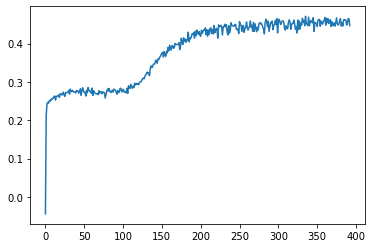

In [9]:
plt.plot(np.asarray(score_list))

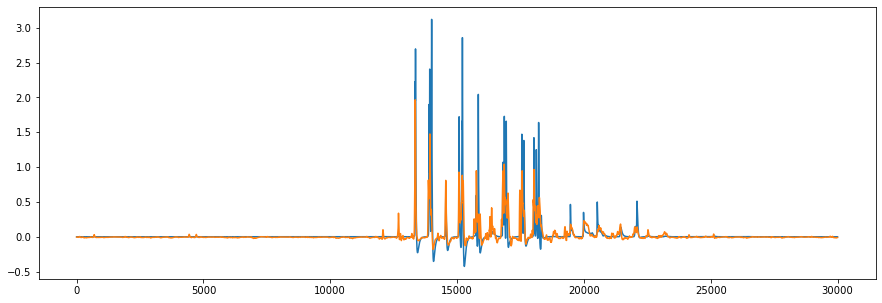

In [13]:
plt.figure(figsize = (15,5))
plt.plot(V_test.cpu().detach().numpy()[5000:35000])
plt.plot(test_V_pred.cpu().detach().numpy())

In [8]:
#torch.save(model.state_dict(), "/media/hdd01/sklee/CA1_clust4-60_noNA/random/glm_s10_h2.pt")